<a href="https://colab.research.google.com/github/airctic/icedata/blob/master/notebooks/dev/bccd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Warning
This notebook is a work in progress document. We are sharing it with the IceVision Community through our Live Code Session (beginners-friendly). If you are interested in attending, please feel free to [join us](http://tinyurl.com/IceData)

## About the BCCD Dataset
The BCCD dataset contains blood cells iamges. It is shared by [cosmicad](https://github.com/cosmicad/dataset) and by [akshaylambda](https://github.com/akshaylamba/all_CELL_data). It contains 364 images with 3 classes ('RBC', 'WBC', 'Platelets'). Be aware, the RBC class is over-represented.

# A Parser Example: Subclassing VOCBBoxParser parser
> **Goal**: This notebook shows how to create a custom VOC parser by subclassing the VOCBBoxParser parser.



## Installing IceVision

!!! warning "Google Colab Dependencies Incompatibilities "
    This issue is specific to Google Colab. The issue shouldn't occur on a local machine.
    Some of our external dependencies are not aligned with the dependencies pre-installed in Google Colab. 
    After pip installing both icevision and icedata (by runnning the cell here below), some errors will eventually pop up.
    To fix this issue, press the **RESTART RUNTIME** button.

In [ ]:
# Installing from PyPi
!pip install icevision[all]

In [53]:
# Instaling from GitHub master
# !pip install jsonschema --upgrade
# !pip install git+git://github.com/icevision/icevision.git#egg=icevision[all] --upgrade

## Imports

In [1]:
from icevision.all import *

## Clone the BCCD dataset repository
Our fork removes some invalid bboxes

In [ ]:
!git clone https://github.com/ai-fast-track/dataset.git

## WARNING: 
Make sure you have already cloned the BCCD dataset using the command shown here above
### Set images and annotations directories

In [3]:
data_dir = Path('dataset')

images_dir = data_dir / 'JPEGImages'
annotations_dir = data_dir / 'Annotations'

In [4]:
images_dir.ls()

(#366) [Path('dataset/JPEGImages/BloodImage_00336.jpg'),Path('dataset/JPEGImages/BloodImage_00261.jpg'),Path('dataset/JPEGImages/BloodImage_00090.jpg'),Path('dataset/JPEGImages/BloodImage_00064.jpg'),Path('dataset/JPEGImages/BloodImage_00047.jpg'),Path('dataset/JPEGImages/BloodImage_00299.jpg'),Path('dataset/JPEGImages/BloodImage_00109.jpg'),Path('dataset/JPEGImages/BloodImage_00258.jpg'),Path('dataset/JPEGImages/BloodImage_00189.jpg'),Path('dataset/JPEGImages/BloodImage_00011.jpg')...]

### Define class_map

In [5]:
class_map = ClassMap(['RBC', 'WBC', 'Platelets'])

In [6]:
class_map.get_name('RBC')

1

### Parser: Use icevision predefined VOC parser

In [7]:
import xml.etree.ElementTree as ET

### Note
The BCCD uses the VOC annotation but the `filepath` field is not properly set in the annotation files. Therefore, we need to subsclass VOCBBoxParser and override the `filepath()` method to fill in the missing information.

In [8]:
class BCCDParser(parsers.VOCBBoxParser):
    def filepath(self, o) -> Union[str, Path]:
        self._filename = self._root.find("filename").text + '.jpg'
        return self.images_dir / self._filename

In [9]:
parser = BCCDParser(annotations_dir=annotations_dir, images_dir=images_dir, class_map=class_map)

### train and validation records

In [10]:
train_records, valid_records = parser.parse()

In [11]:
train_records[0]

{'bboxes': [BBox(pnts=[285, 367, 386, 480]),
  BBox(pnts=[386, 360, 492, 453]),
  BBox(pnts=[293, 67, 402, 167]),
  BBox(pnts=[392, 17, 507, 137]),
  BBox(pnts=[296, 268, 410, 362]),
  BBox(pnts=[203, 1, 321, 89]),
  BBox(pnts=[345, 178, 429, 283]),
  BBox(pnts=[535, 1, 638, 106]),
  BBox(pnts=[415, 146, 519, 253]),
  BBox(pnts=[436, 258, 539, 355]),
  BBox(pnts=[120, 52, 222, 159]),
  BBox(pnts=[518, 134, 613, 235]),
  BBox(pnts=[508, 355, 623, 440]),
  BBox(pnts=[1, 96, 85, 205])],
 'filepath': Path('dataset/JPEGImages/BloodImage_00367.jpg'),
 'height': 480,
 'imageid': 305,
 'labels': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'width': 640}

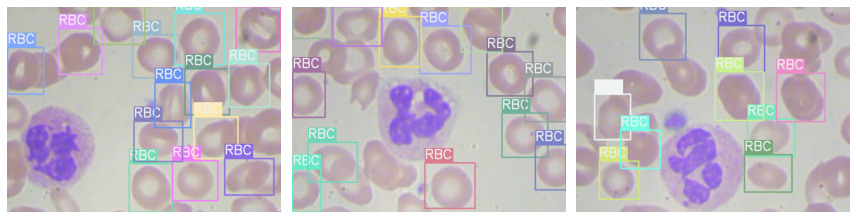

In [12]:
show_records(train_records[:3], ncols=3, class_map=class_map)

## Datasets
### Transforms

In [13]:
presize = 512
size = 384

train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size), tfms.A.Normalize()])

### Train and Validation Dataset Objects

In [14]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

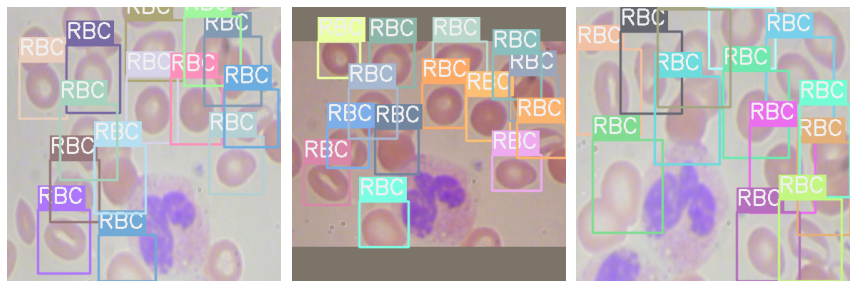

In [15]:
samples = [train_ds[10] for _ in range(3)]
show_samples(samples, class_map=class_map, denormalize_fn=denormalize_imagenet, ncols=3)

### DataLoaders

### Warning
As for now, EfficientDet doesn't work well for this dataset because some predictions return one-pixel or one-line bboxes. We need to further investigate that in order to find out the source of the problem and how it can be fixed

In [16]:
model_type = faster_rcnn # efficientdet

In [17]:
train_dl = model_type.train_dl(train_ds, batch_size=16, num_workers=4, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=16, num_workers=4, shuffle=False)

### Model

In [18]:
# model = model_type.model('tf_efficientdet_lite0', num_classes=len(class_map), img_size=size)
model = model_type.model(num_classes=len(class_map))

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


### Fastai Learner

In [19]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

In [20]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

## Fastai Training
### Learning Rate Finder

SuggestedLRs(lr_min=0.0013182567432522773, lr_steep=9.12010818865383e-07)

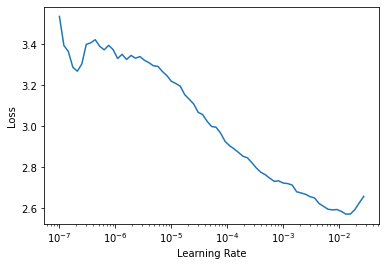

In [21]:
learn.freeze()
learn.lr_find()

### Fine tune: 2 Phases
- Phase 1: Train the head for 3 epochs while freezing the body
- Phase 2: Train both the body and the head during 50 epochs

In [22]:
from fastai.callback.tracker import SaveModelCallback
fname='bccd-faster-rcnn-best'
learn.fine_tune(50, 2e-3, freeze_epochs=3, cbs=SaveModelCallback(monitor='COCOMetric', fname=fname))

epoch,train_loss,valid_loss,COCOMetric,time
0,2.371730,1.660323,0.250068,00:12
1,2.197870,1.431905,0.415473,00:11
2,2.160588,1.576729,0.315556,00:11


Better model found at epoch 0 with COCOMetric value: 0.25006834014243867.
Better model found at epoch 1 with COCOMetric value: 0.415473475434623.


epoch,train_loss,valid_loss,COCOMetric,time
0,0.936082,0.570812,0.516978,00:16
1,0.855573,0.617727,0.488844,00:14
2,0.814733,0.649691,0.446347,00:14
3,0.786091,0.704727,0.391779,00:14
4,0.765411,0.534969,0.543471,00:14
5,0.736199,0.504765,0.542122,00:13
6,0.720384,0.530986,0.592402,00:13
7,0.701206,0.528306,0.600799,00:14
8,0.683331,0.484347,0.614978,00:13
9,0.667415,0.519361,0.602432,00:13


Better model found at epoch 0 with COCOMetric value: 0.5169783501899856.
Better model found at epoch 4 with COCOMetric value: 0.543471005180702.
Better model found at epoch 6 with COCOMetric value: 0.5924015230746118.
Better model found at epoch 7 with COCOMetric value: 0.6007991787116421.
Better model found at epoch 8 with COCOMetric value: 0.6149779663015257.
Better model found at epoch 11 with COCOMetric value: 0.633077670714693.
Better model found at epoch 20 with COCOMetric value: 0.636758344380259.
Better model found at epoch 30 with COCOMetric value: 0.6429488591684139.


## Saving a Model on Google Drive

>Note: In this example, we suppose you have already created a folder called **models** in your Google Drive

In [24]:
## Mount your Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = Path('/content/gdrive/My Drive/')

Mounted at /content/gdrive


### Saving the last model

In [25]:
torch.save(model.state_dict(), root_dir/'models/bccd-faster-rcnn.pth')

### Saving the best model

In [26]:
!ls models

bccd-faster-rcnn-best.pth


In [28]:
!cp models/bccd-faster-rcnn-best.pth /content/gdrive/"My Drive"/models/bccd-faster-rcnn-best.pth

## Show results

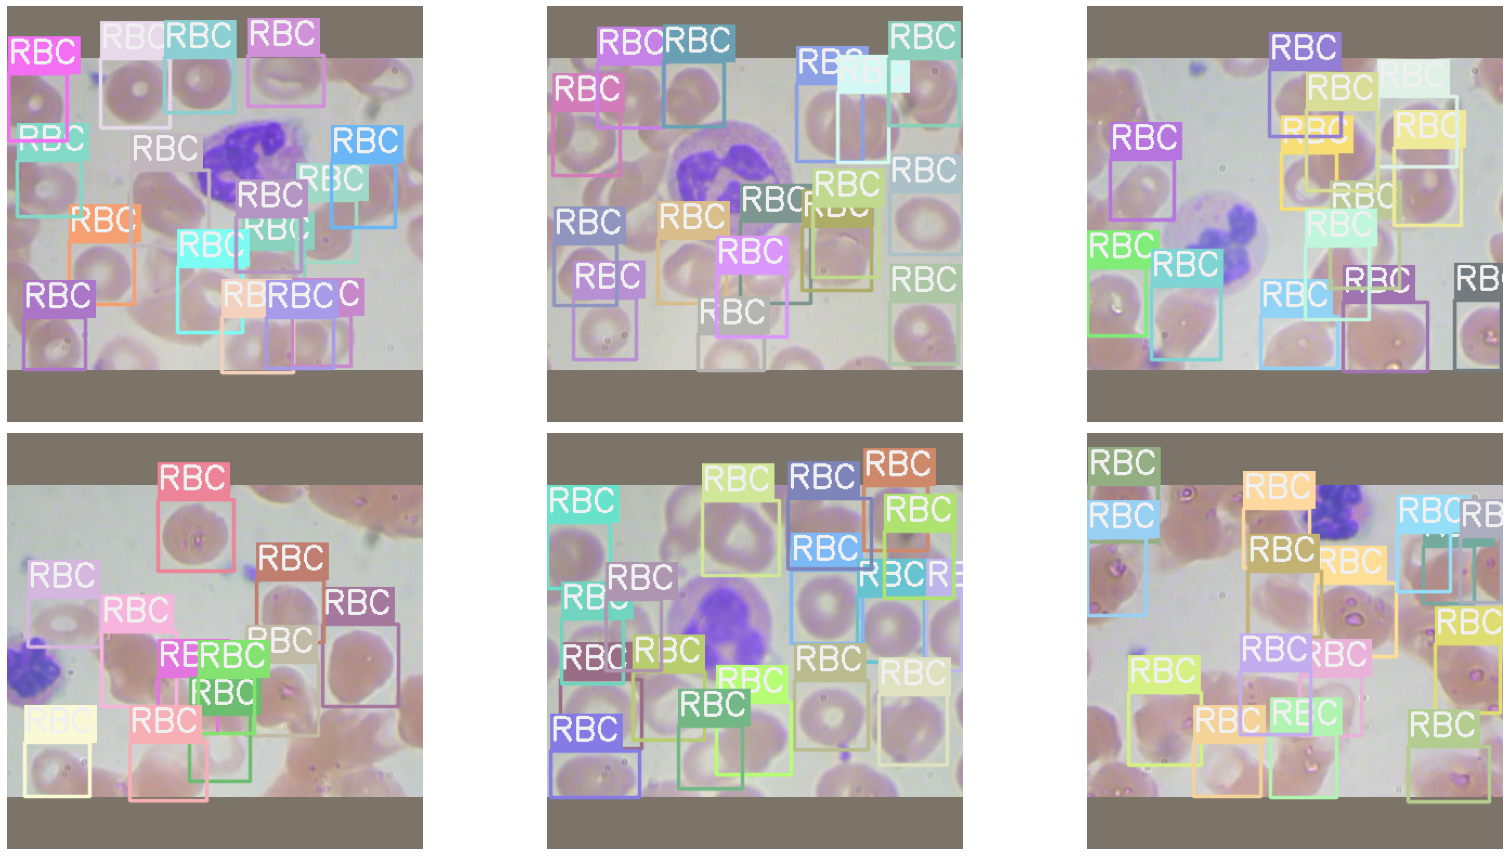

In [23]:
model_type.show_results(model, valid_ds, class_map=class_map)

## Happy Learning!

If you need any assistance, feel free to join our [forum](https://discord.gg/JDBeZYK).